In [1]:
# Import the necessary packages

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import keras
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
import seaborn as sns

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory('/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/train/', 
                                              target_size=(256, 256), 
                                              batch_size=32, 
                                              class_mode='categorical')
test_set = test_datagen.flow_from_directory('/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/test/', 
                                            target_size=(256, 256), 
                                            batch_size=32, 
                                            class_mode='categorical',
                                            shuffle=False)

Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [4]:
train_path='/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/train/'
No_images_per_class = []
Class_name = []
for i in os.listdir(train_path):
  train_class = os.listdir(os.path.join(train_path, i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in No Impairment = 2560 

Number of images in Very Mild Impairment = 2560 

Number of images in Moderate Impairment = 2560 

Number of images in Mild Impairment = 2560 



In [5]:
test_path='/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/test/'
No_images_per_class = []
Class_name = []
for i in os.listdir(test_path):
  train_class = os.listdir(os.path.join(test_path, i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in No Impairment = 640 

Number of images in Very Mild Impairment = 448 

Number of images in Moderate Impairment = 12 

Number of images in Mild Impairment = 179 



In [6]:
from glob import glob
# useful for getting number of output classes
folders = glob('/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/train/*')
print(len(folders))

4


In [7]:
img_width, img_height = 256,256

# Load the ResNet-50 model (pre-trained on ImageNet)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(len(folders), activation='softmax'))


94765736/94765736 [==============================] - 0s 0us/step


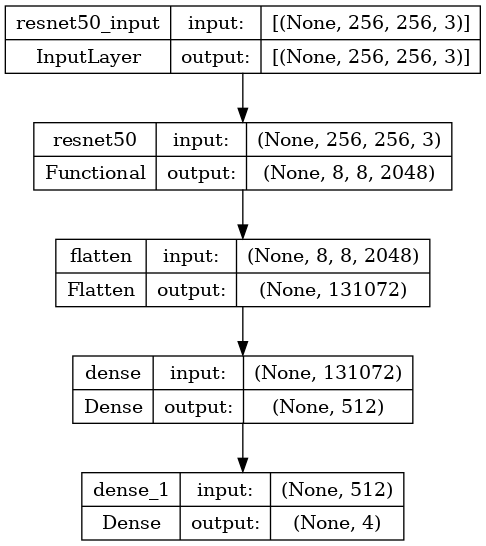

In [8]:
plot_model(model, to_file='resnet50_plot.png', show_shapes=True, show_layer_names=True) #visulaize the model

In [9]:
lr = 0.001
model.compile(Adam(learning_rate=lr),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 512)               67109376  
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 90,699,140
Trainable params: 67,111,428
Non-trainable params: 23,587,712
_________________________________________________________________


In [10]:
file_path="weights.best.hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [11]:
history = model.fit(train_set,
                    steps_per_epoch=train_set.samples//32,
                    epochs=100,
                    validation_data=test_set,
                    validation_steps=test_set.samples//32,
                    callbacks=callbacks_list)

Epoch 1/100
320/320 [==============================] - ETA: 0s - loss: 4.8325 - accuracy: 0.4268
Epoch 1: val_loss improved from inf to 1.41368, saving model to weights.best.hdf5
320/320 [==============================] - 250s 746ms/step - loss: 4.8325 - accuracy: 0.4268 - val_loss: 1.4137 - val_accuracy: 0.4607
Epoch 2/100
320/320 [==============================] - ETA: 0s - loss: 1.1158 - accuracy: 0.5423
Epoch 2: val_loss improved from 1.41368 to 1.07829, saving model to weights.best.hdf5
320/320 [==============================] - 158s 493ms/step - loss: 1.1158 - accuracy: 0.5423 - val_loss: 1.0783 - val_accuracy: 0.5184
Epoch 3/100
320/320 [==============================] - ETA: 0s - loss: 1.0292 - accuracy: 0.5831
Epoch 3: val_loss improved from 1.07829 to 0.85797, saving model to weights.best.hdf5
320/320 [==============================] - 159s 496ms/step - loss: 1.0292 - accuracy: 0.5831 - val_loss: 0.8580 - val_accuracy: 0.5777
Epoch 4/100
320/320 [=============================

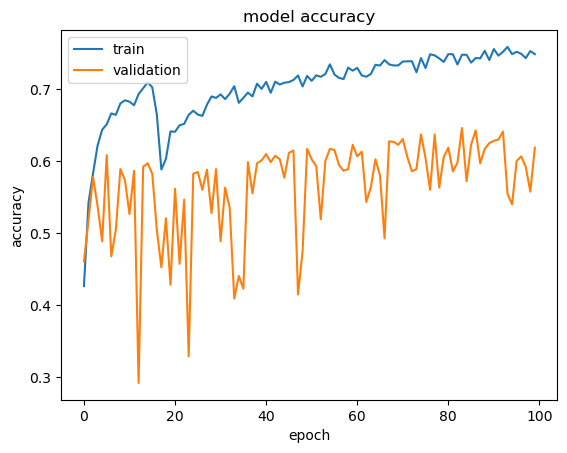

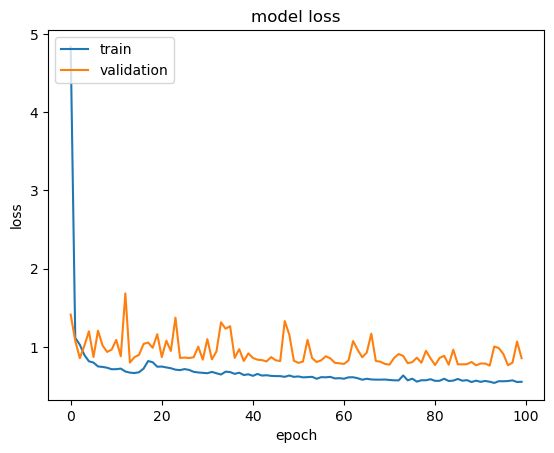

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

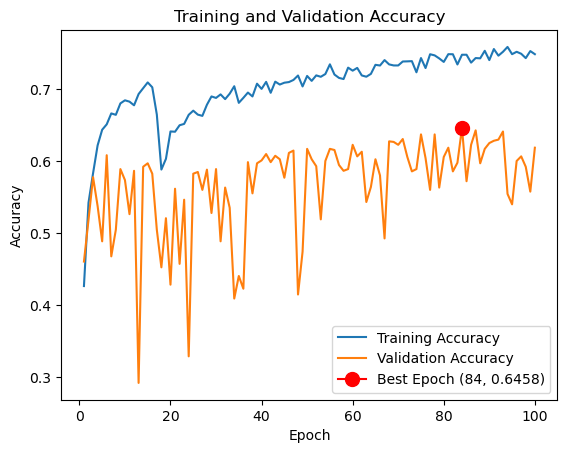

In [13]:
# Extracting the validation accuracy values and finding the epoch with the highest value
val_acc = history.history['val_accuracy']
best_epoch = val_acc.index(max(val_acc)) + 1  # Add 1 to convert index to epoch number

# Plotting the training history
epochs = range(1, len(val_acc) + 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Highlighting the epoch with the highest validation accuracy
plt.plot(best_epoch, val_acc[best_epoch - 1], marker='o', markersize=10, label=f'Best Epoch ({best_epoch}, {val_acc[best_epoch - 1]:.4f})', color='red')

# Adding plot labels and legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [14]:
from tensorflow.keras.models import load_model

model.save('best_weights.h5')

In [15]:
# load model
model = load_model('/kaggle/working/best_weights.h5')

In [16]:
# Evaluate the performance of the model
evaluate = model.evaluate(test_set, steps = test_set.n // 32, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

39/39 [==============================] - 6s 125ms/step - loss: 0.8569 - accuracy: 0.6186
Accuracy Test : 0.6185897588729858


In [17]:
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(test_set.classes, y_pred)
cr = classification_report(test_set.classes, y_pred, target_names=['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'])

40/40 [==============================] - 7s 159ms/step


In [18]:
print(cm)
print(cr)

[[136   5   5  33]
 [  0  12   0   0]
 [ 54   2 377 207]
 [101   5  82 260]]
                      precision    recall  f1-score   support

     Mild Impairment       0.47      0.76      0.58       179
 Moderate Impairment       0.50      1.00      0.67        12
       No Impairment       0.81      0.59      0.68       640
Very Mild Impairment       0.52      0.58      0.55       448

            accuracy                           0.61      1279
           macro avg       0.57      0.73      0.62      1279
        weighted avg       0.66      0.61      0.62      1279



In [19]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_pred,test_set.classes)))
print('Cohen Kappa Score: {:.2f}'.format(cohen_kappa_score(y_pred,test_set.classes)))
print('Recall: {:.2f}'.format(recall_score(test_set.classes, y_pred, average='micro')))
print('F1-score: {:.2f}'.format(f1_score(test_set.classes, y_pred, average='micro')))
print('Precision: {:.2f}'.format(precision_score(test_set.classes, y_pred, average='macro')))


Accuracy: 0.61

Cohen Kappa Score: 0.41
Recall: 0.61
F1-score: 0.61
Precision: 0.57


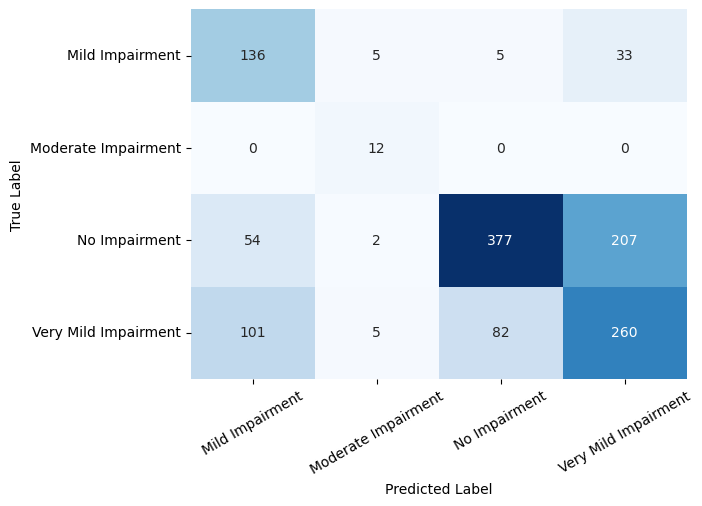

In [20]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'], yticklabels=['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'], cbar=False)
plt.xticks(rotation=30)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()